Visualizing /mnt/sda1/PythonProject/Pig_counting/dataset/TransCrowd/train/images_crop/21_1625696121_origin_1_jpg.rf.a26f1f8809968075e498a8f14a198e8c.jpg with /mnt/sda1/PythonProject/Pig_counting/dataset/TransCrowd/train/gt_density_map_crop/21_1625696121_origin_1_jpg.rf.a26f1f8809968075e498a8f14a198e8c.h5
No points or density map available.


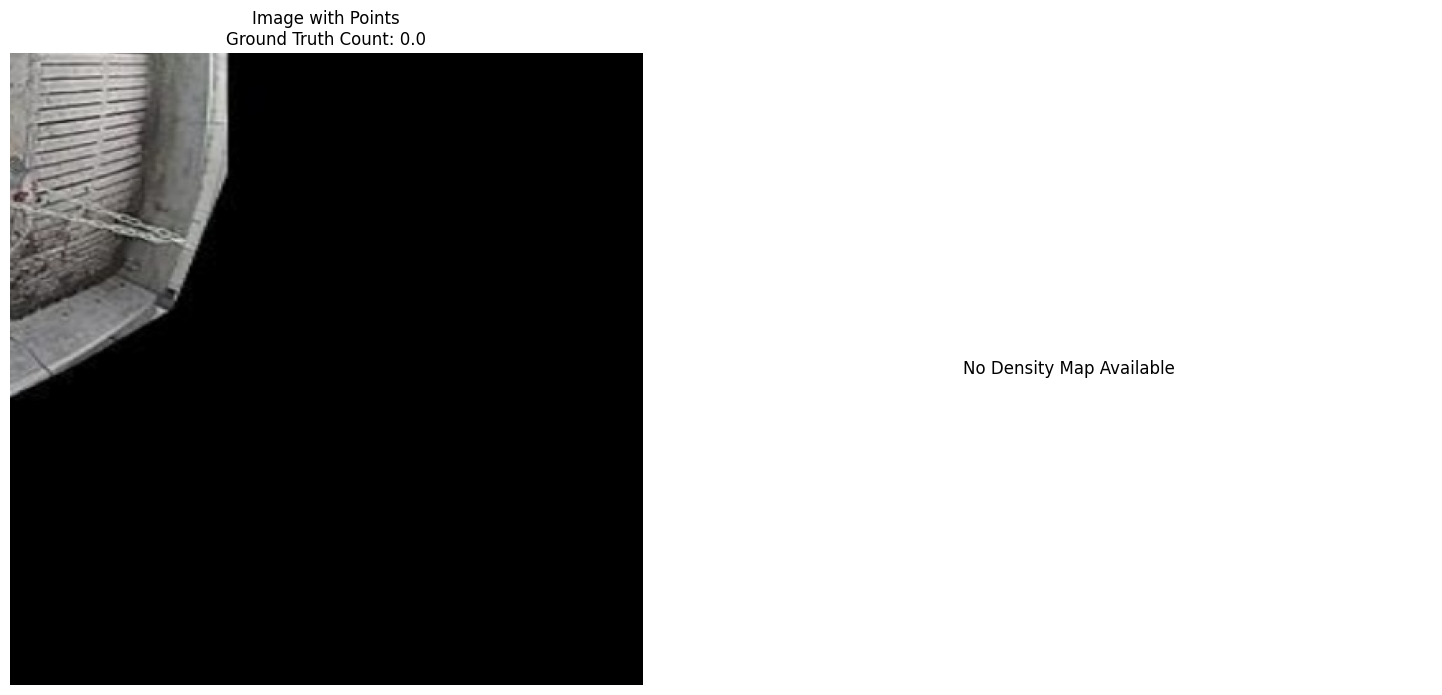

Visualizing /mnt/sda1/PythonProject/Pig_counting/dataset/TransCrowd/train/images_crop/21_209_jpg.rf.ca8d03dc4db3f208607cb0fb5e46411f.jpg with /mnt/sda1/PythonProject/Pig_counting/dataset/TransCrowd/train/gt_density_map_crop/21_209_jpg.rf.ca8d03dc4db3f208607cb0fb5e46411f.h5
No points or density map available.


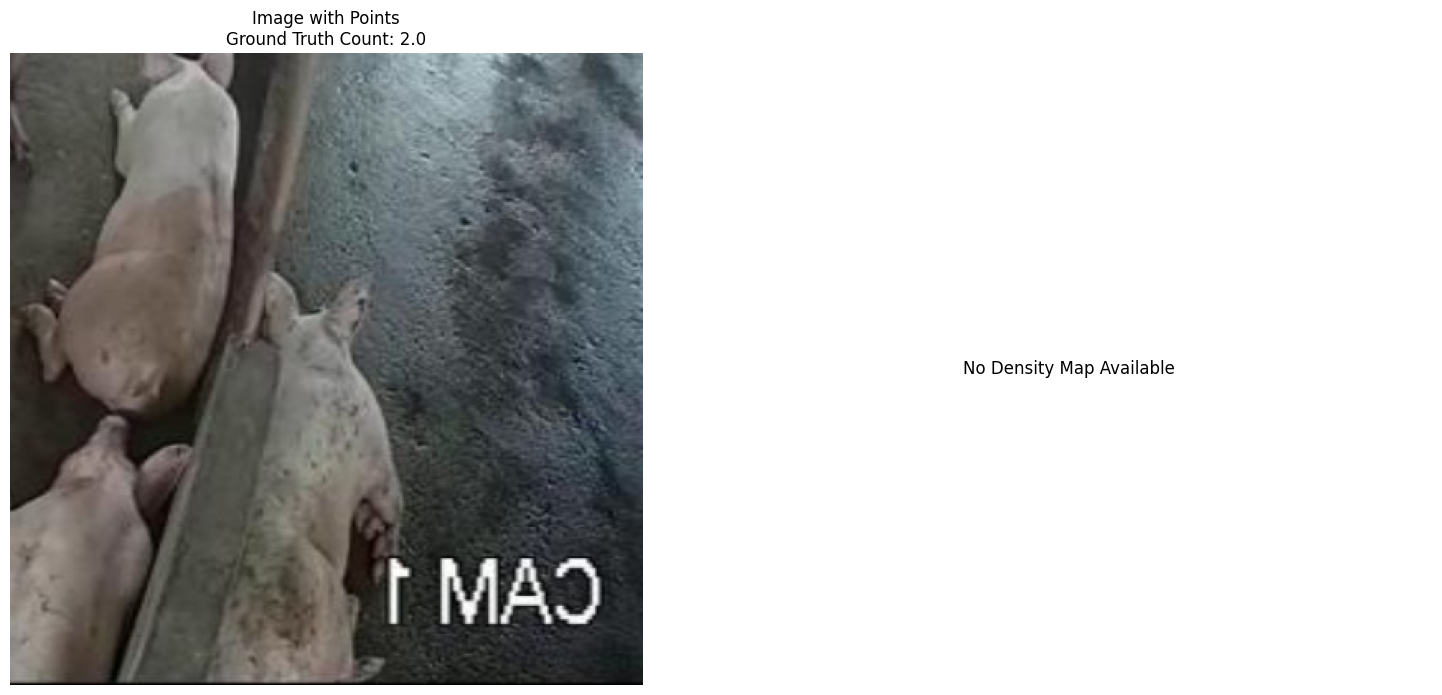

Visualizing /mnt/sda1/PythonProject/Pig_counting/dataset/TransCrowd/train/images_crop/10_257_jpg.rf.0eb456c0a0ea5454b9e95ef20ba44422.jpg with /mnt/sda1/PythonProject/Pig_counting/dataset/TransCrowd/train/gt_density_map_crop/10_257_jpg.rf.0eb456c0a0ea5454b9e95ef20ba44422.h5
No points or density map available.


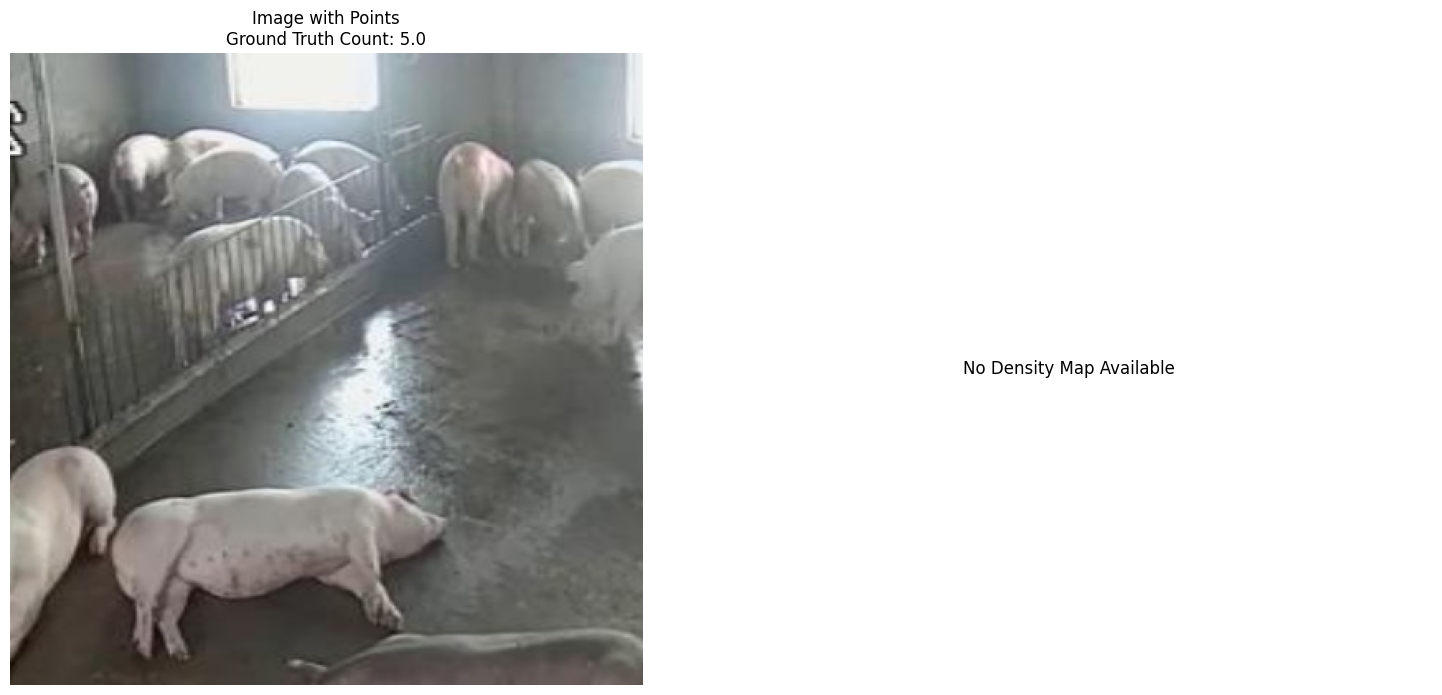

In [10]:
import os
import cv2
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
from scipy.ndimage import gaussian_filter

def generate_density_map(points, img_shape, sigma=15):
    """
    Generate a density map from points using a Gaussian filter.
    
    Args:
        points (np.ndarray): Array of [x, y] coordinates.
        img_shape (tuple): Shape of the image (height, width).
        sigma (float): Standard deviation for Gaussian filter.
    
    Returns:
        np.ndarray: Density map.
    """
    density_map = np.zeros(img_shape[:2], dtype=np.float32)
    for point in points:
        x, y = int(point[0]), int(point[1])
        if 0 <= x < img_shape[1] and 0 <= y < img_shape[0]:
            density_map[y, x] = 1
    density_map = gaussian_filter(density_map, sigma=sigma)
    return density_map

def visualize_ground_truth(image_path, h5_path):
    """
    Visualize an image with its ground truth count, points, and density map.
    
    Args:
        image_path (str): Path to the image file (e.g., .jpg).
        h5_path (str): Path to the corresponding .h5 file.
    """
    # Check if files exist
    if not os.path.exists(image_path) or not os.path.exists(h5_path):
        print(f"Error: One or both files not found.\nImage: {image_path}\nH5: {h5_path}")
        return

    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

    # Load the .h5 file
    try:
        with h5py.File(h5_path, 'r') as hf:
            gt_count = hf['gt_count'][()]  # Ground truth count (scalar)
            points = hf.get('points')      # Optional points (e.g., list of [x, y] coordinates)
            density_map = hf.get('density_map')  # Optional precomputed density map
    except Exception as e:
        print(f"Error loading .h5 file {h5_path}: {e}")
        return

    # Handle points and density map
    if points is not None:
        points = np.array(points)
        if density_map is None:  # Generate density map if not provided
            density_map = generate_density_map(points, img.shape, sigma=15)
            print("Generated density map from points.")
        else:
            density_map = np.array(density_map)
            print("Loaded precomputed density map.")
    else:
        if density_map is not None:
            density_map = np.array(density_map)
            print("Loaded precomputed density map (no points available).")
        else:
            density_map = None
            print("No points or density map available.")

    # Set up the plot with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # Plot 1: Image with points
    ax1.imshow(img)
    if points is not None and len(points) > 0:
        for point in points:
            ax1.scatter(point[0], point[1], c='red', s=20, edgecolors='black')
        print(f"Plotted {len(points)} points.")
    ax1.set_title(f'Image with Points\nGround Truth Count: {gt_count}', fontsize=12)
    ax1.axis('off')

    # Plot 2: Density map
    if density_map is not None:
        ax2.imshow(density_map, cmap='jet')
        ax2.set_title('Density Map', fontsize=12)
        ax2.axis('off')
    else:
        ax2.text(0.5, 0.5, 'No Density Map Available', 
                 horizontalalignment='center', verticalalignment='center', 
                 fontsize=12, transform=ax2.transAxes)
        ax2.axis('off')

    plt.tight_layout()
    plt.show()

def get_image_h5_pairs(image_dir, h5_dir):
    """
    Get pairs of image and corresponding .h5 file paths.
    
    Args:
        image_dir (str): Directory containing image files (.jpg).
        h5_dir (str): Directory containing .h5 files.
    
    Returns:
        list: List of tuples (image_path, h5_path).
    """
    image_paths = glob.glob(os.path.join(image_dir, '*.jpg'))
    pairs = []
    for img_path in image_paths:
        base_name = os.path.basename(img_path).replace('.jpg', '')
        h5_path = os.path.join(h5_dir, base_name + '.h5')
        if os.path.exists(h5_path):
            pairs.append((img_path, h5_path))
    return pairs

if __name__ == "__main__":
    # Set your dataset directories here
    image_dir = '/mnt/sda1/PythonProject/Pig_counting/dataset/TransCrowd/train/images_crop'
    h5_dir = '/mnt/sda1/PythonProject/Pig_counting/dataset/TransCrowd/train/gt_density_map_crop'
    
    # To use the testing set instead, update the paths like this:
    # image_dir = '/mnt/sda1/PythonProject/Pig_counting/dataset/TransCrowd_/val_test/images_crop'
    # h5_dir = '/mnt/sda1/PythonProject/Pig_counting/dataset/TransCrowd_/val_test/gt_density_map_crop'

    # Get pairs of image and .h5 files
    pairs = get_image_h5_pairs(image_dir, h5_dir)
    
    if not pairs:
        print("No matching image and .h5 pairs found. Check your directory paths.")
    else:
        # Shuffle and select up to 3 examples
        random.shuffle(pairs)
        num_examples = min(3, len(pairs))
        for i in range(num_examples):
            img_path, h5_path = pairs[i]
            print(f"Visualizing {img_path} with {h5_path}")
            visualize_ground_truth(img_path, h5_path)